# Variational Inference

## Overview

The Variational Inference tutorial demonstrates how to infer a basic embedding using variational inference. In short, variational inference provides a computationally efficient way to approximate posterior distributions. Posterior distributions are valuable because they enable users to reason about the *uncertainty* associated with an inferred solution, which in turn provides users with a way to report confidence in the solutions.

This tutorial uses the `birds-16` dataset introduced in the [Beginner Tutorial](https://psiz.readthedocs.io/en/latest/src/beginner_tutorial/beginner_tutorial.html) and is divided into three parts:

1. Introduction
2. Model Construction and Inference
3. Visualization

If you would like to run this notebook on your local machine, the file is available [here on PsiZ's GitHub](https://github.com/roads/psiz/blob/main/docs/src/tutorials/vi.ipynb).

## Introduction

When inferring an psychological embedding, we often want to know how much we should believe the inferred solution. When we infer a point estimate model via maximum likelihood (like the Beginner Tutorial), we don't know how how confident we should be in the the embedding coordinates locations. For example, if you moved a particular stimulus coordiante slightly to the left, does it make a difference to the model loss? Or in a more extreme scenario, does it matter if you move a coordinate to the opposite side of the embedding?

One strategy for addressing these questions is to infer a posterior distribution for each stimulus. The shape of the distribution tells you the confidence associated with a embedding coordinate's position. In other words, a distribution that is relatively tight (i.e., low entropy) gives you a precise and high-confidence estiamte of a coordinate's position. On the other hand, if a distribution spans the entire embedding (high entropy), then you have a low-confidence estimate of a coordiante's position.

### Sources of Uncertainty

There are two contributors to uncertainty. The first contributor to uncertainty is a lack of data. Without sufficient data, many different solutions will be equally good and the location of the embedding coordinates will be highly uncertain. The second contributor to uncertainty is due to inconsistent human behavior. As discussed in the Beginner tutorial, two people might give different similarity judgments for the same trial (across-subject variability). The same person might give different similarity judgments for the same trial at different points in time (within-subject variabiltiy). 

When an algorithm infers a posterior distribution, it is not immediately obvious which type of uncertainty dominates. As we collect more data, we can be more confident that any remaining uncertainty is due to inconsistencies in human behavior.

### Strategies for Inferring Posteriors

There are multiple strategies for inferring posterior distributions. Two popular approaches are Markov chain Monte Carlo (MCMC) and variational inference (VI). These two strategies both have their strengths and weakness. When it comes to inferring psychological embeddings, VI has two fundamental advantages. First, VI efficiently scales to problems involving a large number of stimuli. Second, VI gracefully handles the fact that embeddings exhibit different types of invariance. For these two reasons, PsiZ focuses on using VI to infer posterior distributions.

### Variational Inference in a Nutshell

At a high-level VI works by assuming that the posterior looks a certain way (i.e., belongs to a particular family of distributions) and then directly fitting the parameters of the posterior distribution to the training data (i.e., a *likelihood cost*). An additional term in the objective function increasingly penalizes the model if the posterior distribution diverges from the prior distribution (i.e., a *complexity cost*). The complexity cost pressures the posterior distribution to resemble the prior distribution unless there is sufficient data to warrant something otherwise. Together these terms interact to yield a final embedding solution that approximates a posterior.

```{note}
Deriving the equations for VI involves some neat math. If you're interested in a more detailed breakdown, a well-written and accessible tutorial can be found [here](http://krasserm.github.io/2019/03/14/bayesian-neural-networks).
```
```{note}
The equations in this section are taken from {cite:t}`Roads_Love_2021:CVPR`. The original paper is freely available [here, on IEEE Xplore](https://doi.org/10.1109/CVPR46437.2021.00355).
```

In this tutorial, we assume that the posterior distribution associated with each embedding coordinate is charactereized by a multivariate normal and the prior distribution is also a multivariate normal. More precisely, the true posterior $\mathrm{p}(\bm{Z} | \mathcal{D})$ is approximated with the variational distribution $\mathrm{q}(\bm{Z} | \mathcal{D})$ that assumes

```{math}
:label: eq:posterior_assumption
\bm{Z}_{i} \sim \mathcal{N} \left( \bm{\mu}^{(i)}, \bm{\Sigma}^{(i)} \right).
```

The prior distribution of the embedding is
```{math}
:label: eq:prior_assumption
\mathrm{p}(\bm{Z}_{i}) = \mathcal{N} ( 0, \sigma \bm{I}),
```
where $\sigma$ is a scaling parameter fit with the other free parameters.

To limit model complexity, $\bm{\Sigma}^{(i)}$ is constrained to be a diagonal covariance matrix. The set of all free parameters is denoted by $\Theta = \{\bm{\mu}^{(i)}, \bm{\Sigma}^{(i)}, \sigma | 1 \le i \le n \}$, where $n$ indicates the total number of stimuli.

The optimization objective is to minimize the "variational free energy"
```{math}
:label: eq:vi_objective
L(\mathcal{D}, \Theta) = \mathrm{KL} (\mathrm{q}(\bm{Z}|\Theta ) \Vert \mathrm{p}(\bm{Z})) - \mathbb{E}_{\mathrm{q}(\bm{Z} | \Theta)} \log \mathrm{p}(\mathcal{D}|\bm{Z}),
```
where the first term is the *complexity cost* and the second term is the *likelihood cost* {cite}`Hoffman_etal_2013,Ranganath_etal_2014`.

Stepping back, this means that the number of free parameters associated with the embedding module has roughly doubled compared to the MLE approach presented in the Beginner tutorial. For each dimension, you must learn $n$ parameters that specify the the Normal distribution means, $n$ parameters that specify the Normal distribution variances, plus a final parameter associated with the prior.

## Model Construction and Inference

### Preliminaries

Let's start by importing the nessary packages, defining some tutorial settings, and preparing the birds-16 dataset.


In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from pathlib import Path
import shutil

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

import psiz

# Optional CUDA settings. TODO
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# tf.config.run_functions_eagerly(True)

# Define where we want our results to be stored.
fp_project = Path.home() / Path('psiz_examples', 'tutorial', 'vi')
fp_board = fp_project / Path('logs', 'fit')

# Some hardcoded settings for the tutorial.
max_epochs = 1000  # TODO was 1000
batch_size = 128
n_dim = 2

# Directory preparation.
fp_project.mkdir(parents=True, exist_ok=True)
# Remove existing TensorBoard logs.
if fp_board.exists():
    shutil.rmtree(fp_board)

# Load hosted birds-16 dataset.
(obs, catalog) = psiz.datasets.load_dataset('birds-16', verbose=1)

# Partition observations.
obs_train, obs_val, obs_test = psiz.utils.standard_split(obs)
print(
    '\nData Split\n  obs_train:'
    ' {0}\n  obs_val: {1}\n  obs_test: {2}'.format(
        obs_train.n_trial, obs_val.n_trial, obs_test.n_trial
    )
)

# Convert observations to TF dataset.
ds_obs_train = obs_train.as_dataset().shuffle(
    buffer_size=obs_train.n_trial, seed=252, reshuffle_each_iteration=True
).batch(batch_size, drop_remainder=False)
ds_obs_val = obs_val.as_dataset().batch(
    batch_size, drop_remainder=False
)
ds_obs_test = obs_test.as_dataset().batch(
    batch_size, drop_remainder=False
)

Dataset Summary
  n_stimuli: 208
  n_trial: 16292

Data Split
  obs_train: 13033
  obs_val: 1629
  obs_test: 1630


The VI model construction code strongly resembles the MLE construction code. The main difference is the top-most layer defining the embedding module is now a `psiz.keras.layers.EmbeddingVariational` layer. Take a look at the code and then continue to the next section to read more about how the    `EmbeddingVariational` layer works.

In [2]:
def build_model(n_stimuli, n_obs_train, n_dim):
    """Build model.

    Args:
        n_stimuli: Integer indicating the number of stimuli in the
            embedding.
        n_obs_train: Integer indicating the number of training
            observations. Used to determine KL weight for variational
            inference.
        n_dim: Integer specifying the dimensionality of the
            embedding.

    Returns:
        model: A TensorFlow Keras model.

    """
    prior_scale = .2  # An educated guess.
    kl_weight = 1. / n_obs_train

    embedding_posterior = psiz.keras.layers.EmbeddingNormalDiag(
        n_stimuli + 1, n_dim, mask_zero=True,
        scale_initializer=tf.keras.initializers.Constant(
            tfp.math.softplus_inverse(prior_scale).numpy()
        )
    )
    embedding_prior = psiz.keras.layers.EmbeddingShared(
        n_stimuli + 1, n_dim, mask_zero=True,
        embedding=psiz.keras.layers.EmbeddingNormalDiag(
            1, 1,
            loc_initializer=tf.keras.initializers.Constant(0.),
            scale_initializer=tf.keras.initializers.Constant(
                tfp.math.softplus_inverse(prior_scale).numpy()
            ),
            loc_trainable=False,
        )
    )
    stimuli = psiz.keras.layers.EmbeddingVariational(
        posterior=embedding_posterior, prior=embedding_prior,
        kl_weight=kl_weight, kl_n_sample=30
    )

    kernel = psiz.keras.layers.DistanceBased(
        distance=psiz.keras.layers.Minkowski(
            rho_initializer=tf.keras.initializers.Constant(2.),
            w_initializer=tf.keras.initializers.Constant(1.),
            trainable=False
        ),
        similarity=psiz.keras.layers.ExponentialSimilarity(
            trainable=False,
            beta_initializer=tf.keras.initializers.Constant(10.),
            tau_initializer=tf.keras.initializers.Constant(1.),
            gamma_initializer=tf.keras.initializers.Constant(0.),
        )
    )
    model = psiz.keras.models.Rank(
        stimuli=stimuli, kernel=kernel, n_sample=1
    )

    # Compile settings.
    compile_kwargs = {
        'loss': tf.keras.losses.CategoricalCrossentropy(),
        'optimizer': tf.keras.optimizers.Adam(learning_rate=.001),
        'weighted_metrics': [
            tf.keras.metrics.CategoricalCrossentropy(name='cce')
        ]
    }

    model.compile(**compile_kwargs)
    return model

model = build_model(catalog.n_stimuli, obs_train.n_trial, n_dim)

The `EmbeddingVariational` layer takes four arguments. The `posterior` and `prior` arguments define the posterior and prior embedding distribution. The argument `kl_weight` controls the complexity cost and is a function of the number of training examples. The argument `kl_n_sample` controls how many samples are taken in order to approximate the KL divergence between the posterior and prior.

The variable `embedding_posterior` is assigned a stochastic embedding layer where all stimuli are characterized by a multivariate normal distribution with a diagonal covariance.

The variable `embedding_prior` is assigned a stochastic embedding layer representing the prior. The `psiz.keras.layers.EmbeddingShared` layer allows us to share a single multivariate normal distribution amongst all the posteriors. In other words, we need the shapes of the posterior and prior to match.

### Inference

With our model defined, we create some useful callbacks (logging and early stopping) and fit the model.

In [3]:
# Define callbacks.
cb_board = tf.keras.callbacks.TensorBoard(log_dir=fp_board, write_graph=False)
cb_early = tf.keras.callbacks.EarlyStopping(
    'loss', patience=100, mode='min', restore_best_weights=False,
    verbose=1
)
callbacks = [cb_board, cb_early]

# Infer embedding.
model.fit(
    x=ds_obs_train, validation_data=ds_obs_val, epochs=max_epochs,
    callbacks=callbacks, verbose=0
)

# Evaluate sets.
metrics_train = model.evaluate(ds_obs_train, verbose=0, return_dict=True)
metrics_val = model.evaluate(ds_obs_val, verbose=0, return_dict=True)
metrics_test = model.evaluate(ds_obs_test, verbose=0, return_dict=True)

print(
    'Performance\n'
    '          | loss | cce  |\n'
    '    train | {0:.2f} | {1:.2f} |\n'
    '    val   | {2:.2f} | {3:.2f} |\n'
    '    test  | {4:.2f} | {5:.2f} |\n'.format(
        metrics_train['loss'], metrics_train['cce'],
        metrics_val['loss'], metrics_val['cce'],
        metrics_test['loss'], metrics_test['cce']
    )
)

Epoch 361: early stopping
Performance
          | loss | cce  |
    train | 1.80 | 1.72 |
    val   | 1.99 | 1.91 |
    test  | 1.83 | 1.75 |



The `loss` values express the variational free energy. The `cce` values express how well the posterior predicts the data.

## Visualization

We can visualize the 2D embedding by plotting the means and variances of all the stimuli posterior distributions. When plotting the variance, we draw an ellipse representing a 95% Highest Density Estimate (HDI), which is analogous to drawing a 95% confidence interval.

[]

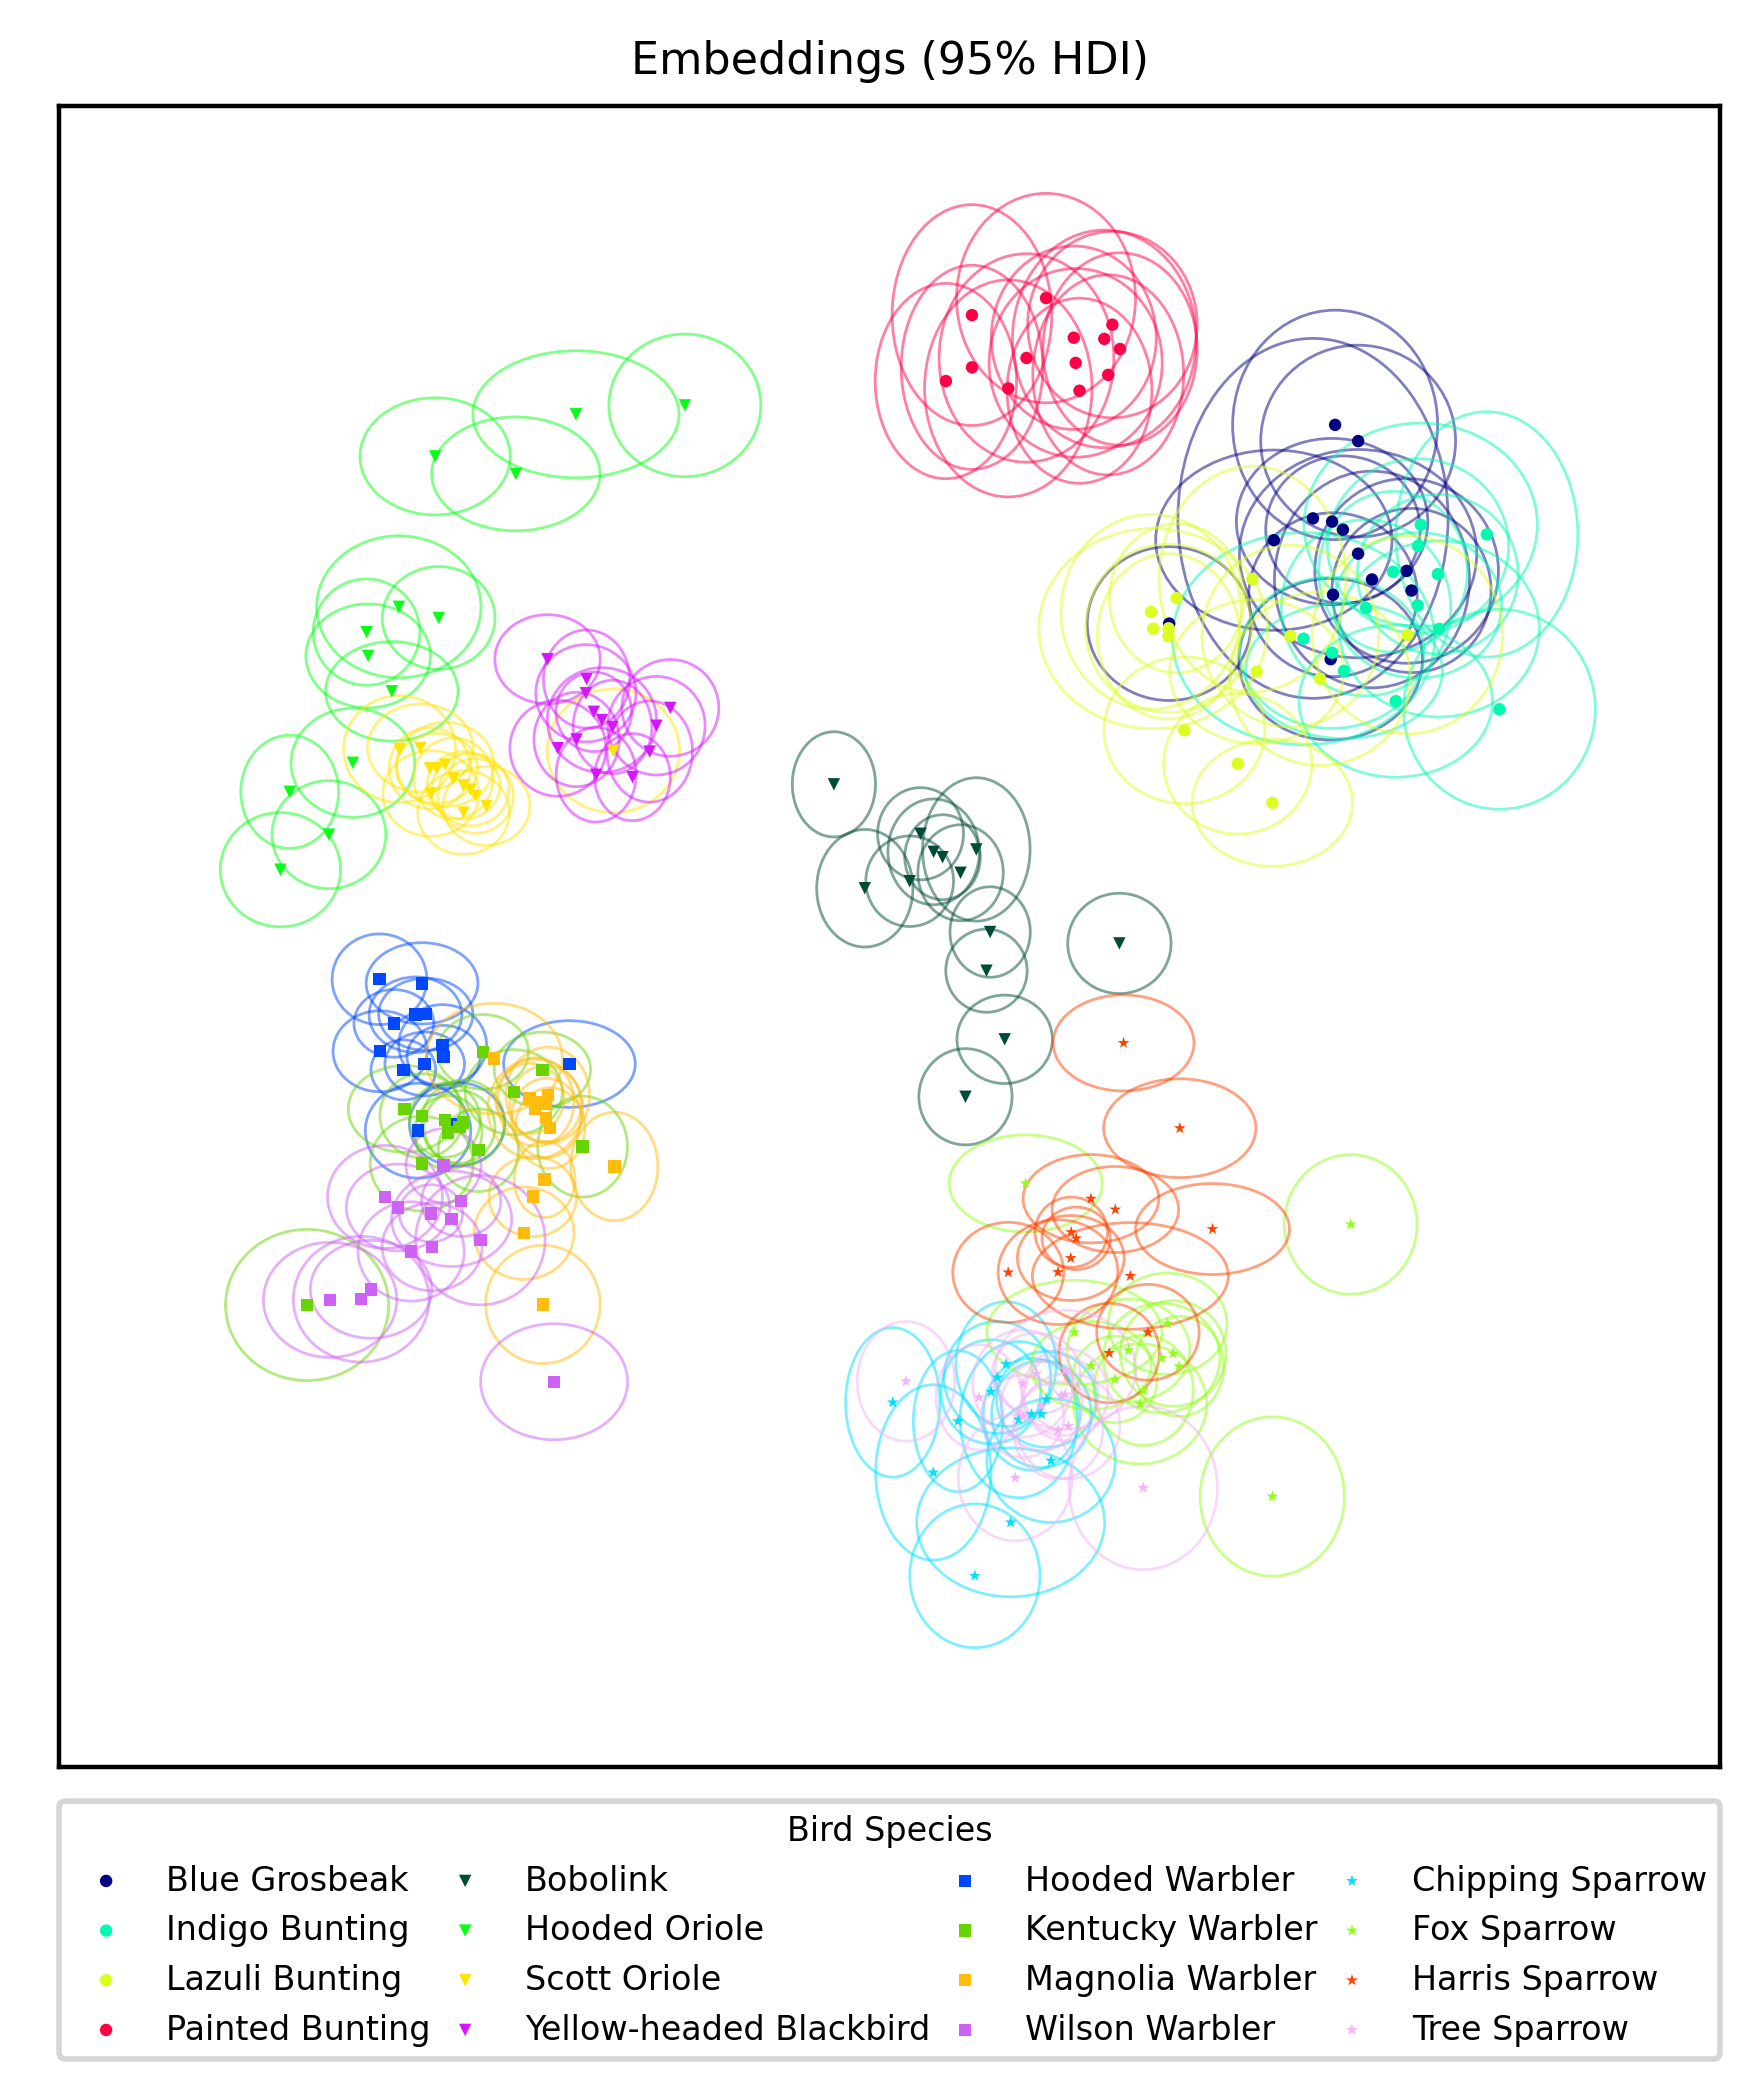

In [35]:
def bird_class_styling():
    """Hard-coded styling for bird classes.
    
    This function assumes it is creating class stylings for the
    birds-16 dataset.

    Returns:
        class_styling: A dictionary of `color` and `marker` arrays; one
            for each class.

    """
    # The class IDs of the bird species. NOTE: The class IDs are not
    # contiguous because `0` denotes the root "Bird" class and '1`,
    # `6`, `11`, `16` denote the taxonomic families.
    class_id_arr = np.array([
        2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20
    ])
    n_class = len(class_id_arr)

    # Define one color per class for plots.
    cmap = matplotlib.cm.get_cmap('gist_ncar')
    norm = matplotlib.colors.Normalize(vmin=0., vmax=n_class)
    class_color_arr = cmap(norm(range(n_class)))
    # Permute order so that similar colors are not in the same family.
    class_color_arr = class_color_arr[[
        0, 4, 8, 12, 1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15
    ]]

    # Use a unique marker for each bird family.
    class_marker_arr = [
        'o', 'o', 'o', 'o',
        'v', 'v', 'v', 'v',
        's', 's', 's', 's',
        '*', '*', '*', '*',
    ]
    
    class_styling = {}
    for class_idx, class_id in enumerate(class_id_arr):
        class_styling[class_id] = {
            'marker': class_marker_arr[class_idx],
            'color': class_color_arr[np.newaxis, class_idx]
        }
    return class_styling


def plot_embedding(ax, model, catalog, class_styling):
    """Plot entire embedding.
    
    Args:
        ax: A Matplotlib axes object.
        model: A PsiZ model.
        catalog: A corresponding PsiZ catalog.
        class_styling: A dictionary of style information for each
            class.

    """
    # Settings
    s = 5
    lw = .5
    alpha = .5
    gs = fig.add_gridspec(1, 1)

    class_id_arr = catalog.stimuli.class_id.values
    unique_class_ids = np.unique(class_id_arr)
    n_class = len(unique_class_ids)

    # Grab embedding distributions.
    dist = model.stimuli.embeddings
    loc, cov = unpack_mvn(dist)
    if model.stimuli.mask_zero:
        # Drop placeholder stimulus.
        loc = loc[1:]
        cov = cov[1:]

    # Center coordinates for prettier plotting.
    loc = loc - np.min(loc, axis=0) - (
        np.max(loc, axis=0) - np.min(loc, axis=0)
    ) / 2

    # Determine embedding limits.
    z_max = 1.3 * np.max(np.abs(loc))
    z_limits = [-z_max, z_max]

    # Draw stimuli modes and 95% HDI ellipses, color-coded by class
    # membership.
    for class_id in unique_class_ids:
        bidx_class = np.equal(class_id_arr, class_id)
        class_label = catalog.class_label[class_id].replace('_',' ')
        
        # Draw stimuli 95% HDI ellipses.
        psiz.mplot.hdi_bvn(
            loc[bidx_class], cov[bidx_class],
            ax=ax, p=.95,
            edgecolor=class_styling[class_id]['color'], lw=lw,
            alpha=alpha, fill=False
        )

        # Draw stimuli modes.
        ax.scatter(
            loc[bidx_class, 0], loc[bidx_class, 1], s=s,
            c=class_styling[class_id]['color'],
            marker=class_styling[class_id]['marker'],
            label=class_label,
            edgecolors='none',
            zorder=100,
        )

    ax.set_xlim(z_limits)
    ax.set_ylim(z_limits)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Embeddings (95% HDI)')
    # ax.legend(
    #     ncol=4, bbox_to_anchor=(0.5, 0.), shadow=True, title="Bird Species"
    # )
    ax.legend(
        loc="upper left", ncol=4, bbox_to_anchor=(0., -0.22, 1.0, 0.2),
        title="Bird Species", mode="expand", borderaxespad=0
    )


def unpack_mvn(dist):
    """Unpack multivariate normal distribution."""
    def diag_to_full_cov(v):
        """Convert diagonal variance to full covariance matrix.

        Assumes `v` represents diagonal variance elements only.
        """
        n_stimuli = v.shape[0]
        n_dim = v.shape[1]
        cov = np.zeros([n_stimuli, n_dim, n_dim])
        for i_stimulus in range(n_stimuli):
            cov[i_stimulus] = np.eye(n_dim) * v[i_stimulus]
        return cov

    loc = dist.mean().numpy()
    v = dist.variance().numpy()

    # Convert to full covariance matrix.
    cov = diag_to_full_cov(v)

    return loc, cov


class_styling = bird_class_styling()

# Plot settings.
small_size = 6
medium_size = 8
large_size = 10
plt.rc('font', size=small_size)
plt.rc('axes', titlesize=medium_size)
plt.rc('axes', labelsize=small_size)
plt.rc('xtick', labelsize=small_size)
plt.rc('ytick', labelsize=small_size)
plt.rc('legend', fontsize=small_size)
plt.rc('figure', titlesize=large_size)

# Create visual of VI model.
fig = plt.figure(figsize=(6.5, 5.5), dpi=400)
gs = fig.add_gridspec(1, 1)

ax = fig.add_subplot(gs[0, 0])
plot_embedding(ax, model, catalog, class_styling)

# gs.tight_layout(fig)
plt.plot()


The visualization reveals a few things. First, all stimuli exhibit some amount of uncertainty, which uncertainty varies a bit, it looks like all stimuli coordinates could be moved slightly without dramatically hurting model performance. Second, no stimulus exhibits massive uncertainty---selecting a random stimulus and moving to the opposite side of the embedding is likely to significantly hurt model performance. Lastly, the visualization shows that while some pairs of species exhibit clusters that are clearly separated based on their means, the corresponding variance ellipses suggest that participants often disagree on their similarity judgments (e.g., Indigo and Lazuli Buntings).

## Summary

This tutorial demonstrated how to infer posterior distributions for embeddings using variational inference. Posterior distributions are valuable because they add a notion of uncertainty or confidence when interpretting the inferred solution.

<!-- TODO example showing multiple frames of posteriors as more data is added -->

<!-- TODO Posterior distributions are also useful when performing active learning, which attempts to identify trials that  -->